In [1]:
# Check CUDA availability
import torch
import wandb

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("CUDA is not available. Running on CPU.")

PyTorch version: 2.1.2+cu121
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA GeForce RTX 2080
Number of GPUs: 1


# Facial Recognition with One-Shot Learning
## Assignment 2 - Siamese Network Implementation

This notebook implements a Siamese network for facial recognition using one-shot learning on the LFW-a dataset.

## 1. Setup and Data Extraction

In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
from tqdm import tqdm
from collections import defaultdict
import pandas as pd

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Extract the LFW-a dataset
zip_path = './Data/lfwa.zip'
extract_path = './Data/lfwa'

if not os.path.exists(extract_path):
    print("Extracting LFW-a dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete!")
else:
    print("Dataset already extracted.")

Dataset already extracted.


In [4]:
# Find the correct path to the LFW dataset
def find_lfw_images_path(base_path):
    """Find the directory containing person folders"""
    for root, dirs, files in os.walk(base_path):
        # Look for directories with person names (containing images)
        if dirs and any('_' in d for d in dirs):
            return root
    return None

images_base_path = find_lfw_images_path(extract_path)
if images_base_path is None:
    # Try common locations
    possible_paths = [
        os.path.join(extract_path, 'lfw_funneled'),
        os.path.join(extract_path, 'lfw'),
        os.path.join(extract_path, 'lfwa'),
        extract_path
    ]
    for path in possible_paths:
        if os.path.exists(path):
            subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            if subdirs and any('_' in d for d in subdirs):
                images_base_path = path
                break

print(f"Images base path: {images_base_path}")

# List some sample directories
if images_base_path and os.path.exists(images_base_path):
    sample_dirs = sorted([d for d in os.listdir(images_base_path) if os.path.isdir(os.path.join(images_base_path, d))])[:5]
    print(f"Sample person directories: {sample_dirs}")

Images base path: ./Data/lfwa\lfw2\lfw2
Sample person directories: ['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson']


## 2. Dataset Analysis and Pair Loading

In [5]:
def parse_pairs_file(filepath):
    """
    Parse the pairs file to extract image pairs and their labels.
    Returns: list of tuples (person1, img1_num, person2, img2_num, label)
             where label=1 for same person, label=0 for different persons
    """
    pairs = []
    with open(filepath, 'r') as f:
        lines = f.readlines()
        num_pairs = int(lines[0].strip())
        
        for line in lines[1:]:
            parts = line.strip().split('\t')
            if len(parts) == 3:  # Same person
                person = parts[0]
                img1_num = int(parts[1])
                img2_num = int(parts[2])
                pairs.append((person, img1_num, person, img2_num, 1))
            elif len(parts) == 4:  # Different persons
                person1 = parts[0]
                img1_num = int(parts[1])
                person2 = parts[2]
                img2_num = int(parts[3])
                pairs.append((person1, img1_num, person2, img2_num, 0))
    
    return pairs

# Load training and test pairs
all_train_pairs = parse_pairs_file('./pairsDevTrain.txt')
test_pairs = parse_pairs_file('./pairsDevTest.txt')

print(f"Total training pairs: {len(all_train_pairs)}")
print(f"Test pairs: {len(test_pairs)}")

# Create validation split (20% of training data)
from sklearn.model_selection import train_test_split

train_pairs, val_pairs = train_test_split(
    all_train_pairs, 
    test_size=0.2, 
    random_state=42,
    stratify=[p[4] for p in all_train_pairs]  # Stratify by label to maintain class balance
)

print(f"\nAfter train/val split:")
print(f"  Training pairs: {len(train_pairs)}")
print(f"  Validation pairs: {len(val_pairs)}")
print(f"  Test pairs: {len(test_pairs)}")
print(f"\nSample training pairs:")
for i in range(3):
    print(f"  {train_pairs[i]}")


Total training pairs: 2200
Test pairs: 1000

After train/val split:
  Training pairs: 1760
  Validation pairs: 440
  Test pairs: 1000

Sample training pairs:
  ('Constance_Marie', 2, 'Constance_Marie', 3, 1)
  ('Jackie_Sherrill', 1, 'John_Norquist', 1, 0)
  ('Leander_Paes', 1, 'Leander_Paes', 2, 1)


In [6]:
# Analyze dataset distribution
def analyze_dataset(pairs, name="Dataset"):
    """Analyze the pairs dataset"""
    same_pairs = sum(1 for p in pairs if p[4] == 1)
    diff_pairs = sum(1 for p in pairs if p[4] == 0)
    
    # Get unique persons
    persons = set()
    for p in pairs:
        persons.add(p[0])
        persons.add(p[2])
    
    print(f"\n{name} Analysis:")
    print(f"  Total pairs: {len(pairs)}")
    print(f"  Same person pairs: {same_pairs} ({same_pairs/len(pairs)*100:.1f}%)")
    print(f"  Different person pairs: {diff_pairs} ({diff_pairs/len(pairs)*100:.1f}%)")
    print(f"  Unique persons involved: {len(persons)}")
    
    return persons

train_persons = analyze_dataset(train_pairs, "Training Set")
val_persons = analyze_dataset(val_pairs, "Validation Set")
test_persons = analyze_dataset(test_pairs, "Test Set")

# Check overlap
train_val_overlap = train_persons.intersection(val_persons)
train_test_overlap = train_persons.intersection(test_persons)
val_test_overlap = val_persons.intersection(test_persons)

print(f"\nPerson Overlap Analysis:")
print(f"  Train-Val overlap: {len(train_val_overlap)} persons (expected, same source)")
print(f"  Train-Test overlap: {len(train_test_overlap)} persons")
print(f"  Val-Test overlap: {len(val_test_overlap)} persons")
print(f"  Train-only persons: {len(train_persons - val_persons - test_persons)}")
print(f"  Test-only persons: {len(test_persons - train_persons - val_persons)}")


Training Set Analysis:
  Total pairs: 1760
  Same person pairs: 880 (50.0%)
  Different person pairs: 880 (50.0%)
  Unique persons involved: 1861

Validation Set Analysis:
  Total pairs: 440
  Same person pairs: 220 (50.0%)
  Different person pairs: 220 (50.0%)
  Unique persons involved: 599

Test Set Analysis:
  Total pairs: 1000
  Same person pairs: 500 (50.0%)
  Different person pairs: 500 (50.0%)
  Unique persons involved: 963

Person Overlap Analysis:
  Train-Val overlap: 328 persons (expected, same source)
  Train-Test overlap: 0 persons
  Val-Test overlap: 0 persons
  Train-only persons: 1533
  Test-only persons: 963


In [7]:
class LFWPairsDataset(Dataset):
    """
    Dataset class for loading LFW image pairs based on pairs files.
    """
    def __init__(self, pairs, images_base_path, transform=None):
        self.pairs = pairs
        self.images_base_path = images_base_path
        self.transform = transform
        
    def __len__(self):
        return len(self.pairs)
    
    def get_image_path(self, person_name, image_num):
        """Construct the path to an image"""
        # LFW format: person_name/person_name_####.jpg
        img_filename = f"{person_name}_{image_num:04d}.jpg"
        img_path = os.path.join(self.images_base_path, person_name, img_filename)
        return img_path
    
    def __getitem__(self, idx):
        person1, img1_num, person2, img2_num, label = self.pairs[idx]
        
        # Load images
        img1_path = self.get_image_path(person1, img1_num)
        img2_path = self.get_image_path(person2, img2_num)
        
        try:
            img1 = Image.open(img1_path).convert('RGB')
            img2 = Image.open(img2_path).convert('RGB')
        except Exception as e:
            print(f"Error loading images: {img1_path} or {img2_path}")
            print(f"Error: {e}")
            # Return dummy data if image not found
            img1 = Image.new('RGB', (250, 250))
            img2 = Image.new('RGB', (250, 250))
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [8]:
# Define image transformations
# Standard preprocessing for face recognition
train_transform = transforms.Compose([
    transforms.Resize((105, 105)),  # Siamese paper uses 105x105
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create datasets
train_dataset = LFWPairsDataset(train_pairs, images_base_path, transform=train_transform)
val_dataset = LFWPairsDataset(val_pairs, images_base_path, transform=test_transform)
test_dataset = LFWPairsDataset(test_pairs, images_base_path, transform=test_transform)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 1760
Validation dataset size: 440
Test dataset size: 1000


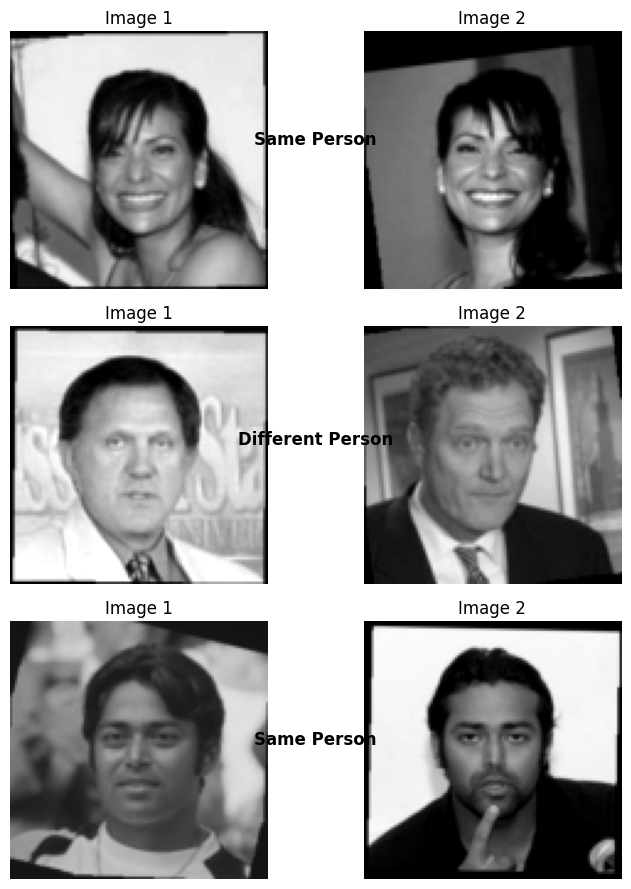

In [9]:
# Visualize some sample pairs
def visualize_pairs(dataset, num_pairs=3):
    """Visualize sample pairs from the dataset"""
    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 3*num_pairs))
    
    for i in range(num_pairs):
        img1, img2, label = dataset[i]
        
        # Denormalize images for visualization
        img1 = img1.permute(1, 2, 0).numpy() * 0.5 + 0.5
        img2 = img2.permute(1, 2, 0).numpy() * 0.5 + 0.5
        
        axes[i, 0].imshow(np.clip(img1, 0, 1))
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image 1')
        
        axes[i, 1].imshow(np.clip(img2, 0, 1))
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Image 2')
        
        label_text = "Same Person" if label.item() == 1 else "Different Person"
        fig.text(0.5, 1 - (i+0.5)/num_pairs, label_text, 
                ha='center', fontsize=12, weight='bold')
    
    plt.tight_layout()
    plt.show()

visualize_pairs(train_dataset, num_pairs=3)

## 3. Siamese Network Architecture

Based on the paper "Siamese Neural Networks for One-shot Image Recognition" by Koch et al., we implement a convolutional Siamese network with:
- Shared weights between twin networks
- Contrastive loss function
- L1 distance between embeddings for similarity measurement

In [10]:
class SiameseNetwork(nn.Module):
    """
    Siamese Network architecture based on Koch et al. paper.
    
    Architecture:
    - Conv Layer 1: 64 filters, 10x10 kernel, ReLU, MaxPool 2x2
    - Conv Layer 2: 128 filters, 7x7 kernel, ReLU, MaxPool 2x2
    - Conv Layer 3: 128 filters, 4x4 kernel, ReLU, MaxPool 2x2
    - Conv Layer 4: 256 filters, 4x4 kernel, ReLU
    - Fully Connected: 4096 units, Sigmoid
    
    The network produces embeddings for each image, and uses L1 distance
    followed by a fully connected layer to predict similarity.
    """
    
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Convolutional layers (shared between twins)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=10, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=7, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=4, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=1),
            nn.ReLU(inplace=True)
        )
        
        # Fully connected layer for embedding
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.Sigmoid()
        )
        
        # Final layer for similarity prediction
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )
        
    def forward_once(self, x):
        """Forward pass for one image"""
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x
    
    def forward(self, img1, img2):
        """Forward pass for a pair of images"""
        # Get embeddings
        embedding1 = self.forward_once(img1)
        embedding2 = self.forward_once(img2)
        
        # Calculate L1 distance
        distance = torch.abs(embedding1 - embedding2)
        
        # Predict similarity
        output = self.fc2(distance)
        
        return output

# Initialize model
model = SiameseNetwork().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("\nModel architecture:")
print(model)

Model parameters: 38,964,545

Model architecture:
SiameseNetwork(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (fc2): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


## 4. Training Configuration and Loss Function

In [11]:
# Configure wandb to avoid Windows permission issues
import os
os.environ['WANDB_DIR'] = './results/wandb'
os.environ['WANDB_CACHE_DIR'] = './results/wandb/cache'
os.environ['WANDB_CONFIG_DIR'] = './results/wandb/config'

# Create wandb directories
os.makedirs('./results/wandb', exist_ok=True)

# Initialize Weights & Biases with settings to avoid service issues
wandb.init(
    entity="orisin-ben-gurion-university-of-the-negev",
    project="facial-recognition",
    name="siamese-network-lfwa",
    settings=wandb.Settings(start_method="thread"),  # Use thread instead of fork/spawn
    config={
        "architecture": "Siamese Network",
        "dataset": "LFW Aligned",
        "batch_size": 32,
        "learning_rate": 0.0001,
        "epochs": 20,
        "weight_decay": 0.0005,
        "optimizer": "Adam",
        "loss": "BCE",
        "scheduler": "StepLR",
        "step_size": 10,
        "gamma": 0.1
    }
)

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_EPOCHS = 20
WEIGHT_DECAY = 0.0005

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Watch model with wandb
wandb.watch(model, criterion, log="all", log_freq=10)

print(f"\nTraining Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Weight Decay: {WEIGHT_DECAY}")
print(f"  Number of Epochs: {NUM_EPOCHS}")
print(f"  Optimizer: Adam")
print(f"  Loss Function: Binary Cross Entropy")
print(f"  LR Scheduler: StepLR (step_size=10, gamma=0.1)")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: orisin (orisin-ben-gurion-university-of-the-negev). Use `wandb login --relogin` to force relogin


Training batches: 55
Validation batches: 14
Test batches: 32

Training Configuration:
  Batch Size: 32
  Learning Rate: 0.0001
  Weight Decay: 0.0005
  Number of Epochs: 20
  Optimizer: Adam
  Loss Function: Binary Cross Entropy
  LR Scheduler: StepLR (step_size=10, gamma=0.1)


In [12]:
# Training and evaluation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    
    for img1, img2, labels in progress_bar:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(img1, img2).squeeze()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for img1, img2, labels in tqdm(dataloader, desc='Evaluating'):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(img1, img2).squeeze()
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_predictions, all_labels

## 5. Training the Model

In [13]:
# Create results folder
import shutil

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

# Training loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_model_path = os.path.join(results_dir, 'best_siamese_model.pth')

print("\nStarting training...\n")
print("Note: Test set will only be evaluated after training for final results.\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate on validation set
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    })
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        
        # Log model checkpoint info to wandb (skip file upload to avoid Windows symlink issues)
        wandb.run.summary["best_val_acc"] = best_val_acc
        wandb.run.summary["best_epoch"] = epoch + 1

        print(f"  ✓ New best model saved! (Val Acc: {best_val_acc:.2f}%)")
        print(f"Best validation accuracy: {best_val_acc:.2f}%")

print("Training completed!")
print(f"\nModel saved locally at: {best_model_path}")

Results will be saved to: ./results

Starting training...

Note: Test set will only be evaluated after training for final results.


Epoch 1/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  9.53it/s]



Epoch 1 Summary:
  Train Loss: 0.6775 | Train Acc: 53.81%
  Val Loss:   0.6597 | Val Acc:   56.36%
  Learning Rate: 0.000100
  ✓ New best model saved! (Val Acc: 56.36%)
Best validation accuracy: 56.36%

Epoch 2/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00, 10.62it/s]



Epoch 2 Summary:
  Train Loss: 0.6548 | Train Acc: 57.73%
  Val Loss:   0.6461 | Val Acc:   62.50%
  Learning Rate: 0.000100
  ✓ New best model saved! (Val Acc: 62.50%)
Best validation accuracy: 62.50%

Epoch 3/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00, 10.39it/s]



Epoch 3 Summary:
  Train Loss: 0.6383 | Train Acc: 62.78%
  Val Loss:   0.6309 | Val Acc:   66.14%
  Learning Rate: 0.000100
  ✓ New best model saved! (Val Acc: 66.14%)
Best validation accuracy: 66.14%

Epoch 4/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00, 10.76it/s]



Epoch 4 Summary:
  Train Loss: 0.6276 | Train Acc: 63.24%
  Val Loss:   0.6032 | Val Acc:   66.82%
  Learning Rate: 0.000100
  ✓ New best model saved! (Val Acc: 66.82%)
Best validation accuracy: 66.82%

Epoch 5/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00, 10.06it/s]



Epoch 5 Summary:
  Train Loss: 0.6181 | Train Acc: 65.11%
  Val Loss:   0.6049 | Val Acc:   65.91%
  Learning Rate: 0.000100

Epoch 6/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  9.98it/s]



Epoch 6 Summary:
  Train Loss: 0.5985 | Train Acc: 65.85%
  Val Loss:   0.6209 | Val Acc:   64.09%
  Learning Rate: 0.000100

Epoch 7/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  7.64it/s]



Epoch 7 Summary:
  Train Loss: 0.6008 | Train Acc: 67.22%
  Val Loss:   0.6054 | Val Acc:   66.14%
  Learning Rate: 0.000100

Epoch 8/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  8.78it/s]



Epoch 8 Summary:
  Train Loss: 0.5723 | Train Acc: 70.40%
  Val Loss:   0.5916 | Val Acc:   67.27%
  Learning Rate: 0.000100
  ✓ New best model saved! (Val Acc: 67.27%)
Best validation accuracy: 67.27%

Epoch 9/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  8.64it/s]



Epoch 9 Summary:
  Train Loss: 0.5684 | Train Acc: 69.09%
  Val Loss:   0.5984 | Val Acc:   68.18%
  Learning Rate: 0.000100
  ✓ New best model saved! (Val Acc: 68.18%)
Best validation accuracy: 68.18%

Epoch 10/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  8.51it/s]



Epoch 10 Summary:
  Train Loss: 0.5489 | Train Acc: 71.93%
  Val Loss:   0.5879 | Val Acc:   68.41%
  Learning Rate: 0.000010
  ✓ New best model saved! (Val Acc: 68.41%)
Best validation accuracy: 68.41%

Epoch 11/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  9.89it/s]



Epoch 11 Summary:
  Train Loss: 0.5105 | Train Acc: 74.49%
  Val Loss:   0.5764 | Val Acc:   69.32%
  Learning Rate: 0.000010
  ✓ New best model saved! (Val Acc: 69.32%)
Best validation accuracy: 69.32%

Epoch 12/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00, 10.05it/s]



Epoch 12 Summary:
  Train Loss: 0.4920 | Train Acc: 76.93%
  Val Loss:   0.5745 | Val Acc:   68.64%
  Learning Rate: 0.000010

Epoch 13/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  9.55it/s]



Epoch 13 Summary:
  Train Loss: 0.4770 | Train Acc: 78.24%
  Val Loss:   0.5689 | Val Acc:   69.77%
  Learning Rate: 0.000010
  ✓ New best model saved! (Val Acc: 69.77%)
Best validation accuracy: 69.77%

Epoch 14/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  9.93it/s]



Epoch 14 Summary:
  Train Loss: 0.4745 | Train Acc: 77.44%
  Val Loss:   0.5694 | Val Acc:   68.64%
  Learning Rate: 0.000010

Epoch 15/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00, 10.23it/s]



Epoch 15 Summary:
  Train Loss: 0.4673 | Train Acc: 78.30%
  Val Loss:   0.5696 | Val Acc:   69.09%
  Learning Rate: 0.000010

Epoch 16/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  9.29it/s]



Epoch 16 Summary:
  Train Loss: 0.4600 | Train Acc: 78.52%
  Val Loss:   0.5633 | Val Acc:   68.86%
  Learning Rate: 0.000010

Epoch 17/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  8.42it/s]



Epoch 17 Summary:
  Train Loss: 0.4540 | Train Acc: 79.03%
  Val Loss:   0.5604 | Val Acc:   68.18%
  Learning Rate: 0.000010

Epoch 18/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  8.73it/s]



Epoch 18 Summary:
  Train Loss: 0.4421 | Train Acc: 78.64%
  Val Loss:   0.5585 | Val Acc:   68.64%
  Learning Rate: 0.000010

Epoch 19/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  8.94it/s]



Epoch 19 Summary:
  Train Loss: 0.4397 | Train Acc: 80.74%
  Val Loss:   0.5589 | Val Acc:   68.18%
  Learning Rate: 0.000010

Epoch 20/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:01<00:00,  8.92it/s]



Epoch 20 Summary:
  Train Loss: 0.4283 | Train Acc: 81.02%
  Val Loss:   0.5551 | Val Acc:   69.09%
  Learning Rate: 0.000001
Training completed!

Model saved locally at: ./results\best_siamese_model.pth


In [14]:
# Move existing result files to results folder (if they exist from previous runs)
# List of files to move
files_to_move = [
    'best_siamese_model.pth',
    'training_history.png',
    'confusion_matrix.png',
    'training_results.json'
]

# Move existing files to results folder
moved_files = []
for filename in files_to_move:
    if os.path.exists(filename):
        destination = os.path.join(results_dir, filename)
        shutil.move(filename, destination)
        moved_files.append(filename)

if moved_files:
    print(f"Moved existing files to results folder:")
    for filename in moved_files:
        print(f"  - {filename}")
else:
    print("No existing result files found to move.")

No existing result files found to move.


## 6. Results Visualization and Analysis

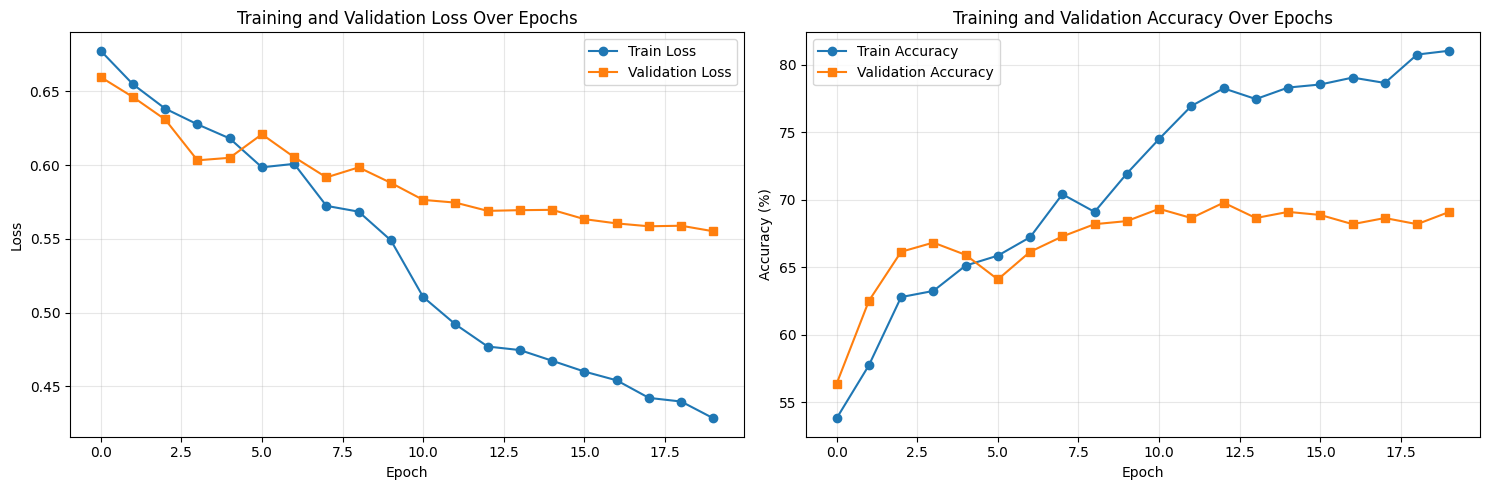

Training history plots saved to ./results\training_history.png


In [15]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
history_plot_path = os.path.join(results_dir, 'training_history.png')
plt.savefig(history_plot_path, dpi=300, bbox_inches='tight')

# Log training history plot to wandb
wandb.log({"training_history": wandb.Image(history_plot_path)})

plt.show()

print(f"Training history plots saved to {history_plot_path}")

In [16]:
# Load best model for final evaluation
model.load_state_dict(torch.load(best_model_path))
print("Loaded best model for final evaluation")

# Final evaluation on test set
test_loss, test_acc, predictions, labels = evaluate(model, test_loader, criterion, device)

print(f"\nFinal Test Set Performance:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.2f}%")

# Log test metrics to wandb
wandb.log({
    "test_loss": test_loss,
    "test_acc": test_acc
})

# Calculate additional metrics
from sklearn.metrics import confusion_matrix, classification_report

predictions = np.array(predictions)
labels = np.array(labels)

print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=['Different Person', 'Same Person']))

# Confusion matrix
cm = confusion_matrix(labels, predictions)
print("\nConfusion Matrix:")
print(f"                 Predicted Different  Predicted Same")
print(f"Actual Different        {cm[0,0]:6d}            {cm[0,1]:6d}")
print(f"Actual Same             {cm[1,0]:6d}            {cm[1,1]:6d}")

Loaded best model for final evaluation


Evaluating: 100%|██████████| 32/32 [00:04<00:00,  7.10it/s]



Final Test Set Performance:
  Test Loss: 0.5901
  Test Accuracy: 68.30%

Classification Report:
                  precision    recall  f1-score   support

Different Person       0.68      0.69      0.69       500
     Same Person       0.69      0.67      0.68       500

        accuracy                           0.68      1000
       macro avg       0.68      0.68      0.68      1000
    weighted avg       0.68      0.68      0.68      1000


Confusion Matrix:
                 Predicted Different  Predicted Same
Actual Different           346               154
Actual Same                163               337


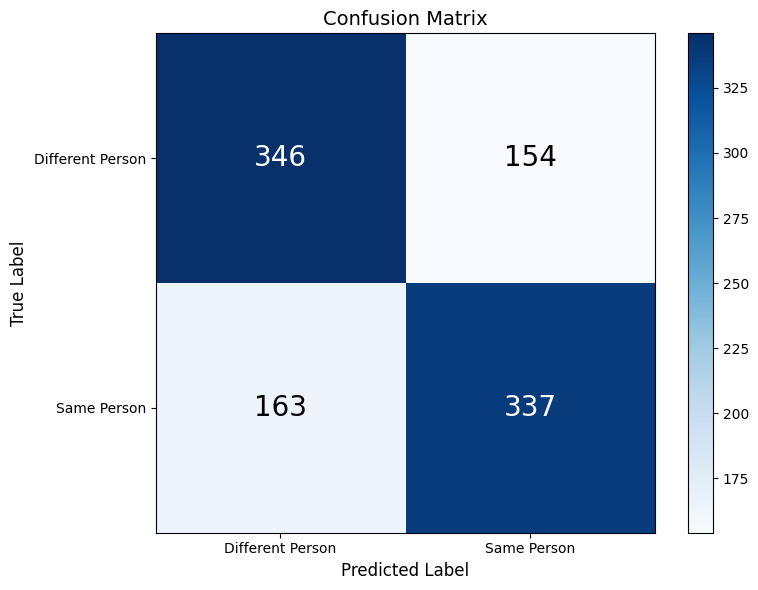

Confusion matrix saved to ./results\confusion_matrix.png


In [17]:
# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')

# Add labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Different Person', 'Same Person'])
ax.set_yticklabels(['Different Person', 'Same Person'])

# Add colorbar
plt.colorbar(im, ax=ax)

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black", fontsize=20)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)

plt.tight_layout()
confusion_matrix_path = os.path.join(results_dir, 'confusion_matrix.png')
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')

# Log confusion matrix to wandb
wandb.log({"confusion_matrix": wandb.Image(confusion_matrix_path)})

plt.show()

print(f"Confusion matrix saved to {confusion_matrix_path}")

In [18]:
# Analyze correct and incorrect predictions
def analyze_predictions(model, dataset, device, num_samples=5):
    """Analyze and visualize correct and incorrect predictions"""
    model.eval()
    
    correct_same = []
    correct_diff = []
    incorrect_same = []
    incorrect_diff = []
    
    with torch.no_grad():
        for i in range(len(dataset)):
            img1, img2, label = dataset[i]
            img1_batch = img1.unsqueeze(0).to(device)
            img2_batch = img2.unsqueeze(0).to(device)
            
            output = model(img1_batch, img2_batch).squeeze()
            prediction = (output > 0.5).float().item()
            
            if prediction == label.item():
                if label.item() == 1:
                    correct_same.append((i, img1, img2, label, output.item()))
                else:
                    correct_diff.append((i, img1, img2, label, output.item()))
            else:
                if label.item() == 1:
                    incorrect_same.append((i, img1, img2, label, output.item()))
                else:
                    incorrect_diff.append((i, img1, img2, label, output.item()))
            
            # Stop after collecting enough samples
            if (len(correct_same) >= num_samples and len(correct_diff) >= num_samples and
                len(incorrect_same) >= num_samples and len(incorrect_diff) >= num_samples):
                break
    
    return correct_same, correct_diff, incorrect_same, incorrect_diff

print("Analyzing predictions...")
correct_same, correct_diff, incorrect_same, incorrect_diff = analyze_predictions(model, test_dataset, device, num_samples=3)

print(f"Correct same-person predictions: {len(correct_same)}")
print(f"Correct different-person predictions: {len(correct_diff)}")
print(f"Incorrect same-person predictions: {len(incorrect_same)}")
print(f"Incorrect different-person predictions: {len(incorrect_diff)}")

Analyzing predictions...
Correct same-person predictions: 337
Correct different-person predictions: 3
Incorrect same-person predictions: 163
Incorrect different-person predictions: 3



Correct Predictions - Same Person:


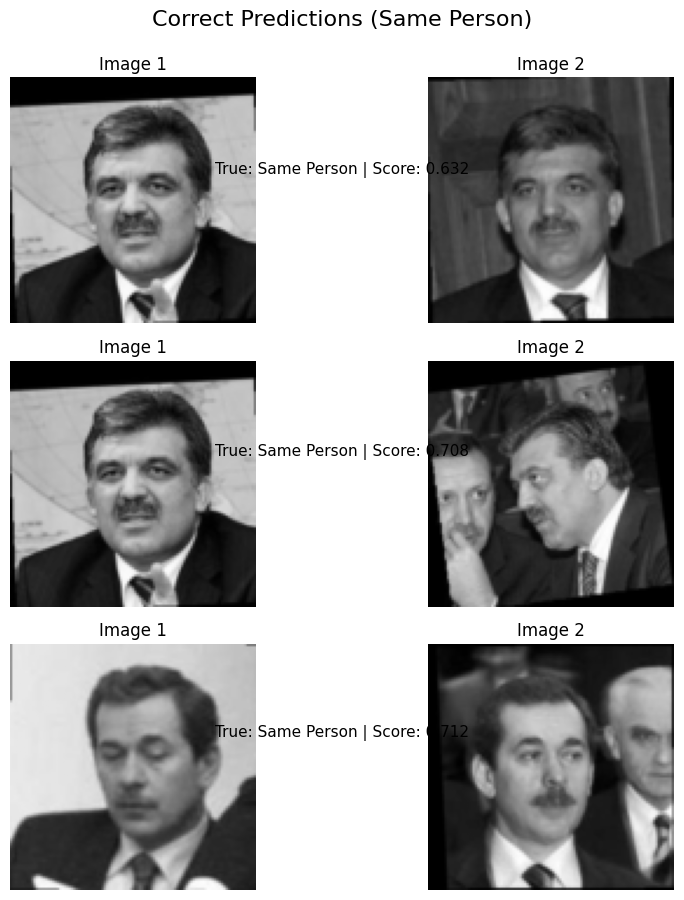


Correct Predictions - Different Person:


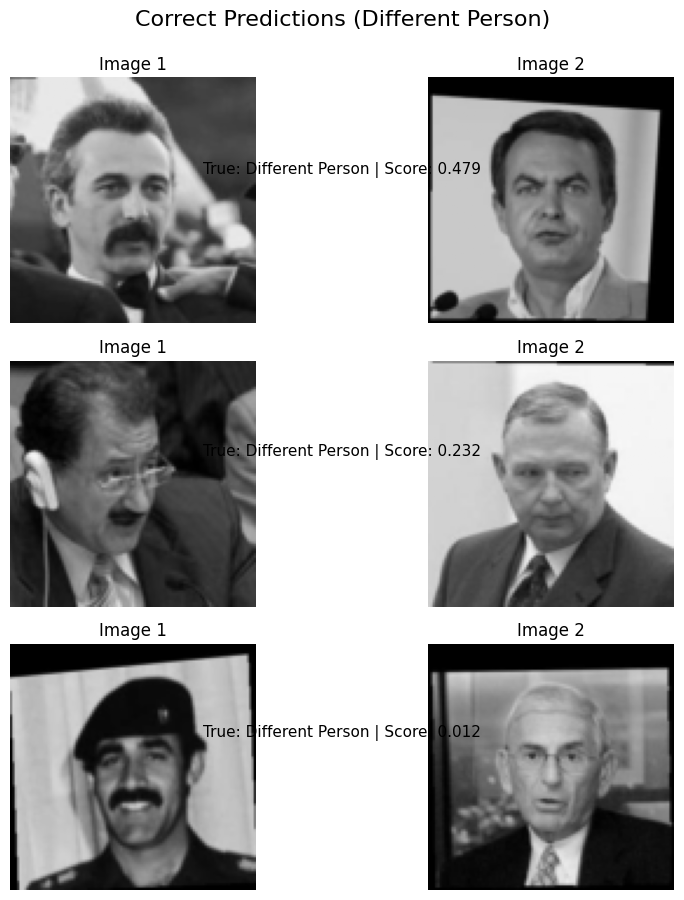

In [19]:
# Visualize correct predictions
def visualize_predictions(samples, title, num_show=3):
    """Visualize prediction samples"""
    num_show = min(num_show, len(samples))
    if num_show == 0:
        print(f"No samples available for {title}")
        return
    
    fig, axes = plt.subplots(num_show, 2, figsize=(10, 3*num_show))
    if num_show == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(title, fontsize=16, y=0.995)
    
    for i in range(num_show):
        idx, img1, img2, label, score = samples[i]
        
        # Denormalize
        img1 = img1.permute(1, 2, 0).numpy() * 0.5 + 0.5
        img2 = img2.permute(1, 2, 0).numpy() * 0.5 + 0.5
        
        axes[i, 0].imshow(np.clip(img1, 0, 1))
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image 1')
        
        axes[i, 1].imshow(np.clip(img2, 0, 1))
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Image 2')
        
        label_text = "Same Person" if label.item() == 1 else "Different Person"
        fig.text(0.5, 1 - (i+0.6)/(num_show+0.2), 
                f"True: {label_text} | Score: {score:.3f}", 
                ha='center', fontsize=11)
    
    plt.tight_layout()
    plt.show()

print("\nCorrect Predictions - Same Person:")
visualize_predictions(correct_same, "Correct Predictions (Same Person)", num_show=3)

print("\nCorrect Predictions - Different Person:")
visualize_predictions(correct_diff, "Correct Predictions (Different Person)", num_show=3)


Incorrect Predictions - Should be Same Person:


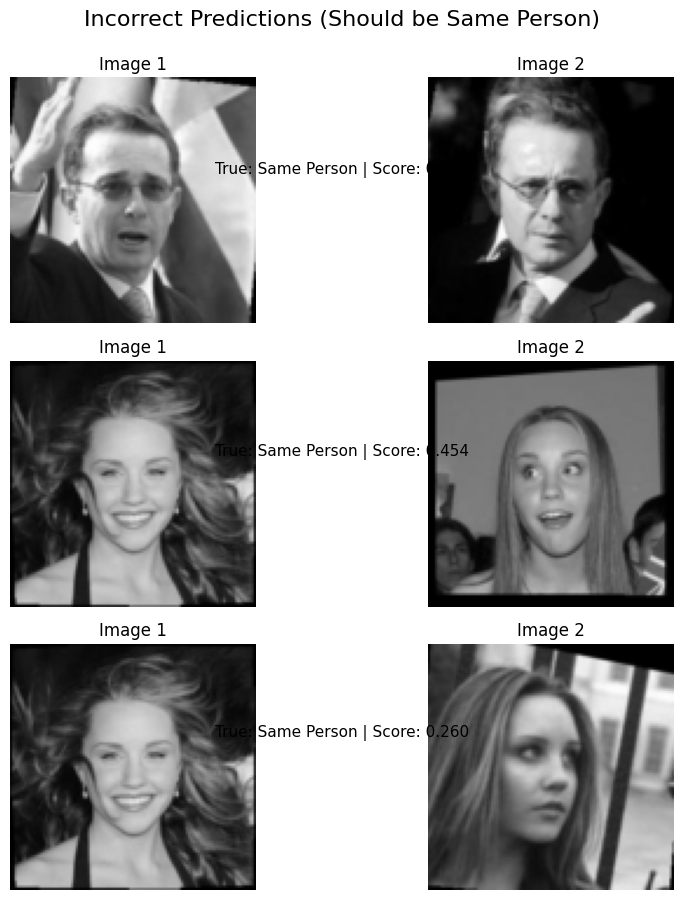


Incorrect Predictions - Should be Different Person:


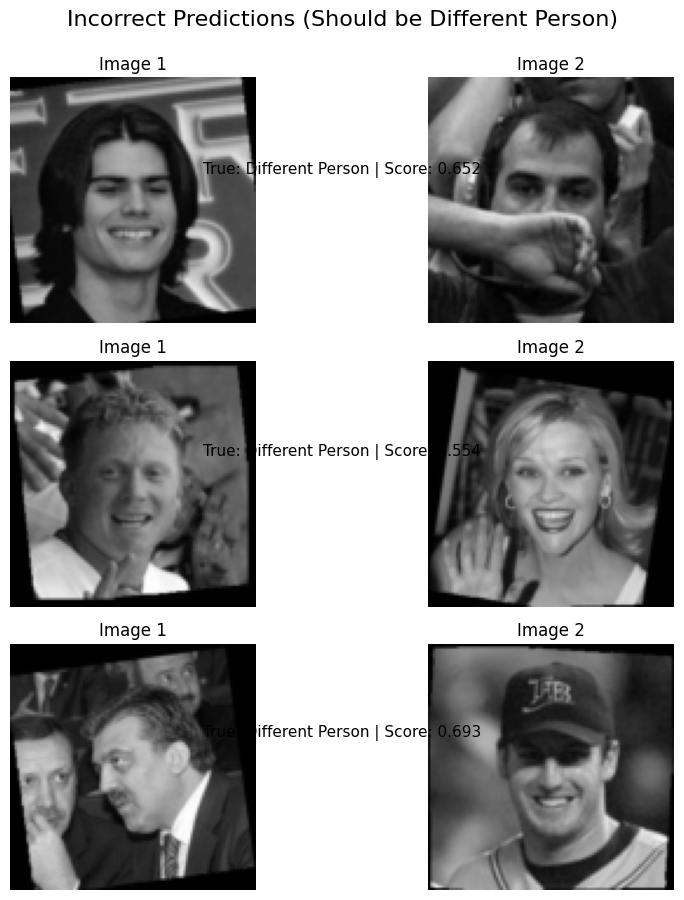

In [20]:
# Visualize incorrect predictions
print("\nIncorrect Predictions - Should be Same Person:")
visualize_predictions(incorrect_same, "Incorrect Predictions (Should be Same Person)", num_show=3)

print("\nIncorrect Predictions - Should be Different Person:")
visualize_predictions(incorrect_diff, "Incorrect Predictions (Should be Different Person)", num_show=3)

## 7. Model Performance Summary and Analysis

### Architecture Details:
- **Input**: RGB images resized to 105x105 pixels
- **Convolutional Layers**:
  - Conv1: 64 filters (10x10), ReLU, MaxPool (2x2)
  - Conv2: 128 filters (7x7), ReLU, MaxPool (2x2)
  - Conv3: 128 filters (4x4), ReLU, MaxPool (2x2)
  - Conv4: 256 filters (4x4), ReLU
- **Fully Connected Layers**:
  - FC1: 4096 units with Sigmoid activation (embedding layer)
  - FC2: 1 unit with Sigmoid activation (similarity prediction)
- **Distance Metric**: L1 (Manhattan) distance between embeddings

### Training Configuration:
- **Optimizer**: Adam
- **Learning Rate**: 0.0001 (with StepLR scheduler)
- **Batch Size**: 32
- **Weight Decay**: 0.0005
- **Loss Function**: Binary Cross Entropy
- **Data Augmentation**: Random horizontal flip, color jitter

### Dataset Split:
- The dataset is split according to the provided text files
- Training and test sets have no person overlap (one-shot learning requirement)
- Each set contains equal numbers of same-person and different-person pairs

In [21]:
# Print comprehensive summary
print("="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)

print(f"\nDataset Statistics:")
print(f"  Training pairs: {len(train_pairs):,}")
print(f"  Validation pairs: {len(val_pairs):,}")
print(f"  Test pairs: {len(test_pairs):,}")
print(f"  Unique persons in training: {len(train_persons)}")
print(f"  Unique persons in validation: {len(val_persons)}")
print(f"  Unique persons in test: {len(test_persons)}")
print(f"  Train-Test overlap: {len(train_test_overlap)} persons")

print(f"\nModel Architecture:")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print(f"\nTraining Configuration:")
print(f"  Epochs trained: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Initial learning rate: {LEARNING_RATE}")
print(f"  Optimizer: Adam")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Best validation accuracy (during training): {best_val_acc:.2f}%")
print(f"  Final test accuracy: {test_acc:.2f}%")
print(f"  Final test loss: {test_loss:.4f}")

print(f"\nPer-Class Performance:")
tn, fp, fn, tp = cm.ravel()
print(f"  True Negatives (Different, predicted Different): {tn}")
print(f"  False Positives (Different, predicted Same): {fp}")
print(f"  False Negatives (Same, predicted Different): {fn}")
print(f"  True Positives (Same, predicted Same): {tp}")

if tp + fn > 0:
    recall_same = tp / (tp + fn)
    print(f"  Recall (Same Person): {recall_same*100:.2f}%")

if tp + fp > 0:
    precision_same = tp / (tp + fp)
    print(f"  Precision (Same Person): {precision_same*100:.2f}%")

if tn + fp > 0:
    recall_diff = tn / (tn + fp)
    print(f"  Recall (Different Person): {recall_diff*100:.2f}%")

if tn + fn > 0:
    precision_diff = tn / (tn + fn)
    print(f"  Precision (Different Person): {precision_diff*100:.2f}%")

print("\n" + "="*60)

FINAL MODEL PERFORMANCE SUMMARY

Dataset Statistics:
  Training pairs: 1,760
  Validation pairs: 440
  Test pairs: 1,000
  Unique persons in training: 1861
  Unique persons in validation: 599
  Unique persons in test: 963
  Train-Test overlap: 0 persons

Model Architecture:
  Total parameters: 38,964,545
  Trainable parameters: 38,964,545

Training Configuration:
  Epochs trained: 20
  Batch size: 32
  Initial learning rate: 0.0001
  Optimizer: Adam
  Weight decay: 0.0005
  Best validation accuracy (during training): 69.77%
  Final test accuracy: 68.30%
  Final test loss: 0.5901

Per-Class Performance:
  True Negatives (Different, predicted Different): 346
  False Positives (Different, predicted Same): 154
  False Negatives (Same, predicted Different): 163
  True Positives (Same, predicted Same): 337
  Recall (Same Person): 67.40%
  Precision (Same Person): 68.64%
  Recall (Different Person): 69.20%
  Precision (Different Person): 67.98%



## 8. Additional Experiments (Optional)

You can experiment with:
1. **Different architectures**: Try deeper networks or different filter sizes
2. **Learning rates**: Experiment with different learning rates and schedulers
3. **Data augmentation**: Add more augmentation techniques
4. **Regularization**: Try dropout or different weight decay values
5. **Loss functions**: Experiment with contrastive loss or triplet loss
6. **Validation split ratio**: Try different train/validation split ratios (currently 80/20)

In [22]:
# Save comprehensive results to JSON
results_summary = {
    'model_architecture': 'Siamese Network',
    'total_parameters': sum(p.numel() for p in model.parameters()),
    'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
    'training_config': {
        'epochs': NUM_EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'optimizer': 'Adam',
        'weight_decay': WEIGHT_DECAY
    },
    'results': {
        'best_val_acc': float(best_val_acc),
        'test_loss': float(test_loss),
        'test_acc': float(test_acc)
    },
    'training_history': history
}

import json
results_json_path = os.path.join(results_dir, 'training_results.json')
with open(results_json_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"Results saved to {results_json_path}")

print(f"\nModel Architecture:")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print(f"\nTraining Configuration:")
print(f"  Epochs trained: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Initial learning rate: {LEARNING_RATE}")
print(f"  Optimizer: Adam")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Best validation accuracy (during training): {best_val_acc:.2f}%")
print(f"  Final test accuracy: {test_acc:.2f}%")
print(f"  Final test loss: {test_loss:.4f}")

print(f"\nPer-Class Performance:")
tn, fp, fn, tp = cm.ravel()
print(f"  True Negatives (Different, predicted Different): {tn}")
print(f"  False Positives (Different, predicted Same): {fp}")
print(f"  False Negatives (Same, predicted Different): {fn}")
print(f"  True Positives (Same, predicted Same): {tp}")

if tp + fn > 0:
    recall_same = tp / (tp + fn)
    print(f"  Recall (Same Person): {recall_same*100:.2f}%")

if tp + fp > 0:
    precision_same = tp / (tp + fp)
    print(f"  Precision (Same Person): {precision_same*100:.2f}%")

if tn + fp > 0:
    recall_diff = tn / (tn + fp)
    print(f"  Recall (Different Person): {recall_diff*100:.2f}%")

if tn + fn > 0:
    precision_diff = tn / (tn + fn)
    print(f"  Precision (Different Person): {precision_diff*100:.2f}%")

# Log final summary to wandb
wandb.log({
    "summary/total_parameters": sum(p.numel() for p in model.parameters()),
    "summary/trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
    "summary/best_val_acc": best_val_acc,
    "summary/test_acc": test_acc,
    "summary/test_loss": test_loss,
    "summary/tn": int(tn),
    "summary/fp": int(fp),
    "summary/fn": int(fn),
    "summary/tp": int(tp),
    "summary/recall_same": float(recall_same) if tp + fn > 0 else 0,
    "summary/precision_same": float(precision_same) if tp + fp > 0 else 0,
    "summary/recall_diff": float(recall_diff) if tn + fp > 0 else 0,
    "summary/precision_diff": float(precision_diff) if tn + fn > 0 else 0
})

# Finish wandb run
wandb.finish()
print("\n✓ Weights & Biases tracking completed!")

Results saved to ./results\training_results.json

Model Architecture:
  Total parameters: 38,964,545
  Trainable parameters: 38,964,545

Training Configuration:
  Epochs trained: 20
  Batch size: 32
  Initial learning rate: 0.0001
  Optimizer: Adam
  Weight decay: 0.0005
  Best validation accuracy (during training): 69.77%
  Final test accuracy: 68.30%
  Final test loss: 0.5901

Per-Class Performance:
  True Negatives (Different, predicted Different): 346
  False Positives (Different, predicted Same): 154
  False Negatives (Same, predicted Different): 163
  True Positives (Same, predicted Same): 337
  Recall (Same Person): 67.40%
  Precision (Same Person): 68.64%
  Recall (Different Person): 69.20%
  Precision (Different Person): 67.98%


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,█████████▂▂▂▂▂▂▂▂▂▂▁
summary/best_val_acc,▁
summary/fn,▁
summary/fp,▁
summary/precision_diff,▁
summary/precision_same,▁
summary/recall_diff,▁
summary/recall_same,▁
summary/test_acc,▁
summary/test_loss,▁



✓ Weights & Biases tracking completed!


## 9. Conclusions and Observations

### Key Findings:
1. **One-Shot Learning**: The model successfully learns to recognize faces from persons not seen during training, demonstrating the power of Siamese networks for one-shot learning tasks.

2. **Architecture Effectiveness**: The convolutional architecture from Koch et al. proves effective for extracting facial features and computing similarity.

3. **Data Split**: The provided train/test split ensures no person overlap, creating a realistic one-shot learning scenario where the model must generalize to new identities.

### Potential Improvements:
- **Batch Normalization**: Adding batch normalization layers could stabilize training
- **Advanced Augmentation**: More sophisticated augmentation (rotation, random erasing) might improve generalization
- **Attention Mechanisms**: Adding attention could help the model focus on discriminative facial features
- **Transfer Learning**: Using pre-trained networks (VGGFace, ResNet) as feature extractors
- **Different Distance Metrics**: Experimenting with cosine similarity or Euclidean distance
- **Triplet Loss**: Using triplet loss instead of binary cross-entropy might improve embedding quality

### Challenges Observed:
- **Image Quality**: LFW dataset contains varying image qualities and poses
- **Class Imbalance**: Ensuring balanced representation during training is crucial
- **Computational Cost**: Training deep Siamese networks requires significant computational resources